### Importy

In [5]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

try:
    import bodynavigation.chest_localization as chest_localization
    reload(bodynavigation.chest_localization)
    print "Importovano chest_localization"

except:
    print "Nelze importovat chest_localization"
    pass

Importovano chest_localization


## Automatická detekce žeber - úvod
Před řešením úlohy si položme dotaz: "Co člověk o žebrech ví a jak je nalezne v CT snímku?"

Nabízí se využít následujících vlastností, které u žeber předpokládáme:
1. vysoká intenzita - kosti mají vyšší intenzitu než jiné tkáně při zobrazení na CT
- velká vzdálenost od středu trupu
    - mezi žebry a povrchem těla již nebývají žádné tkáně s podobně vysokou intenzitou
- "úzké" objekty v ose z
    - odfiltrování "vysokých" oblastí s vysokou intenzitou
- poloha v horní části trupu
- jejich poloha je částečně spjatá s polohou plic
    - možnost využití již implementované metoda *get_lungs()*
    
Vlastnosti 2 a 5 jsou využívány v metodě *area_filter()* z balíku ***chest_localization***. 

#### 1. Vysoká intenzita
Kosti mají v CT snímku zpravidla vysokou intenzitu. Zde se jako řešení nabízí vhodné prahování.
Problémem je nalezení optimální hodnoty prahu. Dále je možné, že hodnoty intenzit
kostí a některých orgánů se značně prolínají. V takovém případě je nalezení optimálního prahu
velice problematické a většinou takový práh, který by vyfiltroval všechny ostatní struktury a
přitom zachoval většinu kostí, ani neexistuje. 

Prahování však i přesto bude užitečné. Místo o hlavní metodu se ale bude jednat spíše o aditivní omezení, například stanovení minimální intenzity, které musí detekované objekty nabývat.

##### 1.1. Prahování
Nejjednodušší metodou pro segmentaci obrazu je prahování. Hodí se především pro úlohy, kdy se snažíme rozpoznávat objekty s výrazně odlišným jasem oproti okolí, což pro tuto úlohu platí. Prahování obrazu zde bude ale jen prvním krokem, který spíše, než aby žebra rovnou oddělil od všech ostatních struktur, což ostatně ani nezvládne (viz výše), pouze odfiltruje značné množství objektů a upraví tak obraz pro další zpracování.

##### 1.2. Vyhlazování konvolučními filtry
Konvoluce je užitečným nástrojem, když máme zašumělá vstupní data. Například pomocí konvoluce snímku s konvolučním jádrem, které je dostatečně "vysoké" v ose *z*, lze jednoduše detekovat objekty s vysokou intenzitou, pro které platí, že mají takto vysokou intenzitu i ve velkém množství řezů nad a pod sebou. Takto lze pomocí aditivního prahování spolehlivě detekovat například páteř a při snížení prahu také řada orgánů se zvýšenou intenzitou. Žebra jsou díky své malé rozlehlosti v této ose ignorována. 

#### 2. Velká vzdálenost od středu trupu
Informace o předpokládaném umístění žeber je, jak se později ukáže, nejvíce vypovídající. Jedná se tedy o stěžejní příznak, který bude v nějakém vztahu se vzdáleností od předem stanovaného objektu. Bylo by žádoucí, aby takovýto objekt byl co nejvíce rigidní a také podobný ve všech snímcích.

Mohlo by se zdát, že dobrou volbou je počítat vzdálenost od povrchu těla, což je velmi jednoduché na implementaci, když známe masku *self.body*. Tento přístup ale, bohužel, nesplňuje ani jednu z výše uvedených podmínek. Povrch těla je díky měkkým tkáním silně nerigidní. Navíc platí, že různí lidé mají různá množství podkožního tuku, což by vedlo ke značné nekonzistenci mezi jednotlivými CT snímky.

Další možností je počítání vzdálenosti od středu trupu, což by sice zmírnilo vysokou odlišnost mezi více snímky, ale stále by nebylo možné zvolit optimální práh, který by odlišil žebra od ostatních objektů v obraze, jelikož takový filtr by detekoval pouze zcela kruhovité oblasti. Jednotlivá žebra jsou ale od středu trupu různě vzdálena. To ostatně platí i v případě vzdálenosti od povrchu těla, zmíněné výše.

Ideálním objektem, od kterého jsou žebra vždy stejně vzdálena, je hrudní koš samotný. K jeho nalezení totiž nepotřebujeme odfiltrovat všechny nežádoucí objekty uvnitř trupu jako při detekci žeber. Vnitřek hrudního koše je v tuto chvíli nepodstatný. Co je podstatné je jeho obrys, který se snažíme najít. K nalezení obrysu hrudního koše je zapotřebí odstranit vše, co se nachází se mezi ním a povrchem těla. U takovýchto tkání můžeme předpokládat nízkou intenzitu v obraze. Bude je tedy jednoduché oddělit od žeber, které mají vysokou intenzitu. Využití těchto znalostí a implementace této myšlenky bude popsána níže i s popisem použitých technik zpracování digitalizovaného obrazu.

## Proces detekce žeber a hrudníku
Prvním krokem je načtení potřebných objektů, tedy:
- self.body - binární maska těla se poté upraví tak, aby neobsahovala některé nežádoucí artefakty
- self.lungs
- self.dist_coronal()

V následujících krocích se vytvoří řada filtrů:
- **final_area_filter** - binární maska hrudníku
- **location_filter** - specifkuje úzké pásmo, které se vnější stranou dotýká binární masky hrudníku a ve které musí žebra bezpodmínečně ležet. V ideálním případě by byla šířka tohoto pásma rovná šířce jednoho žebra.
- **intensity_filter** - maska, která obsahuje oblasti splňující pravidlo minimální intenzity a ležící poblíž objektů splňujících pravidlo výrazně zvýšené intenzity
- **deep_struct_filter** - vyčistí obraz od objektů "vysokých" v ose *z*

Posledním krokem bude oříznutí obrazu v ose *z*, jelikož všechny výše uvedené podmínky splňuje i pánev, která by tak byla chybně nalezena.


### Chest localization
Modul pro detekci hrudního koše a žeber. V následujících odstavcích je popsána řada metod, které obsahuje a které korespondují s řadou výše zmíněných filtrů.

#### Final area filter
Hlavní a zároveň časově nejnáročnějším procesem v detekci žeber je detekce hrudníku.

Jako řešení se nabízí vytvořit masku, která by aproximovala tvar hrudního koše. Obrys hrudníku lze aproximovat konvexním obalem žeber. Ty lze detekovat prostým prahováním s využitím minimálního prahu intenzity kostí. Takovéto prahování samozřejmě neodfiltruje velké množství objektů uvnitř hrudního koše, což ale na konvexní obal nemá vliv. Důležité je, že dojde k odfiltrování měkké podkožní tkáně. 

Otázkou je, jak ale určit konvexní obal v 3D prostoru. Tento proces lze obejít spočtením konvexního obalu po řezech. Po naprahování zůstane jen binární obraz, který obsahuje informaci o kostech a orgánech s vyšší intenzitou. Poté se vybírají jednotlivé řezy v ose *z* a součtem s daným počtem okolních řezů se vytvoří jednotlivé řezy masky. Prahováním poté vznikne binární maska. Proces tvorby binární masky je vidět na následujícím obrázku.

<img src="../doc/chest_images/mask.png">

Z výsledné binární masky se teprve spočtou konvexní obaly pro příslušné řezy.

<img src="../doc/chest_images/bone_step_hull-001.png">

V některých spodních řezech bývají žebra méně zastoupena a lehce se tak může stát, že hranice konvexního obalu budou procházet dokonce středem trupu, což by finálně vedlo k detekci některých orgánů jako přímo naléhajících na obrys hrudního koše. Proto se využívá ještě binární maska plic, která vnikne sumací přes všechny řezy, zmenšením a následnou projekcí (ve smyslu sjednocení) do všech řezů binární masky konvexních obalů.

Tato maska však ještě nepředstavuje výsledný hrudní koš, jelikož při výpočet konvexního obalu významně ovlivní páteř. Konvexní obal naléhá na ní a nikoliv na okolní, jak je požadováno. Je tedy zapotřebí získat masku, která není za určitou hranicí frontální roviny konvexní, ale před ní ano. Takovouto hranici lze vypočítat pomocí bodynavigation. Zbylou část, která nebude konvexním obalem, je ale nutné určit tak, aby byla zcela vyplněná. To u metody součtu několika okolních řezů zajistit nelze. Tudíž je počítána jiná maska, která vniká podobným způsobem, ale místo několika okolních řezů vzniká sumací přes všechny řezy obrázku. Před frontální hranicí se spočítá konvexní obal a za ní se jen vyplní díry. 3D maska pak vznikne projekcí jedné a té samé masky do všech řezů. 

Výsledná maska bude poté průnikem této celkové masky a masky spočtené po řezech.

<img src="../doc/chest_images/final-area-filter-001.png">

Nakonec ještě dojde k oříznutí v ose *z* pro nalezení finální masky hrudníku. Tento proces je popsán níže.





#### Location filter
Dalším krokem je specifikace maximální vzdálenosti, kterou nesmí objekty překročit, pokud mají být označeny jako žebra. Místo celého obalu hrudníku tak získáme jen tenký pás oblasti.

#### Intensity filter
Nejedná se o pouhé prahování. Zvolí se práh, který je výrazně vyšší než stanovený minimální práh pro detekci kostí a naprahuje se. K velice řídkému binárnímu obrazu se přidají pixely, které jsou dostatečně blízko a které splňují pravidlo minimálního prahu intenzity.

#### Deep struct filter
Tento filtr slouží spíše jen pro vyčištění od nežádoucích objektů, a to takových, které jsou "hluboké" v ose *z*. Tento problém nastával především u spodních řezů, kde žebra nebyla zastoupena podél celého obvodu hrudníku, jehož hranice se nepatrně přiblížila ke středu řezu. Tento efekt také částečně zmírnilo použití zmenšené masky plic při hledání binární masky obrazu. 

#### Osa *z*
Nakonec ořízneme obraz v ose *z*. Pokud bychom tak neučinili, všechny výše uvedené podmínky by splnila pánev, která by tak byla chybně nalezena. Naštěstí je od žeber velmi dobře oddělitelná, a to právě polohou v zetové souřadnici. Stejné oříznutí se provede i pro masku hrudníku. Metoda nalezení optimálního prahu je zřejmá i z obrázku níže:

<img src="chest_images/z_osa_001-sliver.png">

Graf množství výskytu žeber v jednotlivých řezech se vyhladí, aby bylo možné najít skutečné lokální minimum. To pak určí hodnotu prahu. Výsledkem bude, že binární maska žeber i hrudníku bude v řezech nižších, než je nalezený práh, nulová.


## Detekce žeber a hrudníku - volání a vizualizace

Ve zbylé části si můžete vyzkoušet detekci žeber pro různá data. Stačí přepsat parametr *pattern*.

### Načtení dat

In [6]:
# O kolikata data se jedna
pattern = "%03d" % 1

# Nacteni dat
orig_data, ref_data, vs_mm, vs_mm1 = chest_localization.make_data(pattern)
# Zakladni uprava dat a vytvoreni objektu body_navigation
bona_object, data3dr_tmp = chest_localization.make_basic_improvement(orig_data, vs_mm)    
# mame tedy objekt bodynavigation a obraz, se kterym budeme pracovat


['C:\\Users\\Mirab\\Documents\\Py\\lisatest\\data\\medical\\orig\\sliver07/training\\liver-orig001.mhd']
['C:\\Users\\Mirab\\Documents\\Py\\lisatest\\data\\medical\\orig\\sliver07/training\\liver-seg001.mhd']


### Detekce žeber

C:\Miniconda2\envs\lisa\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


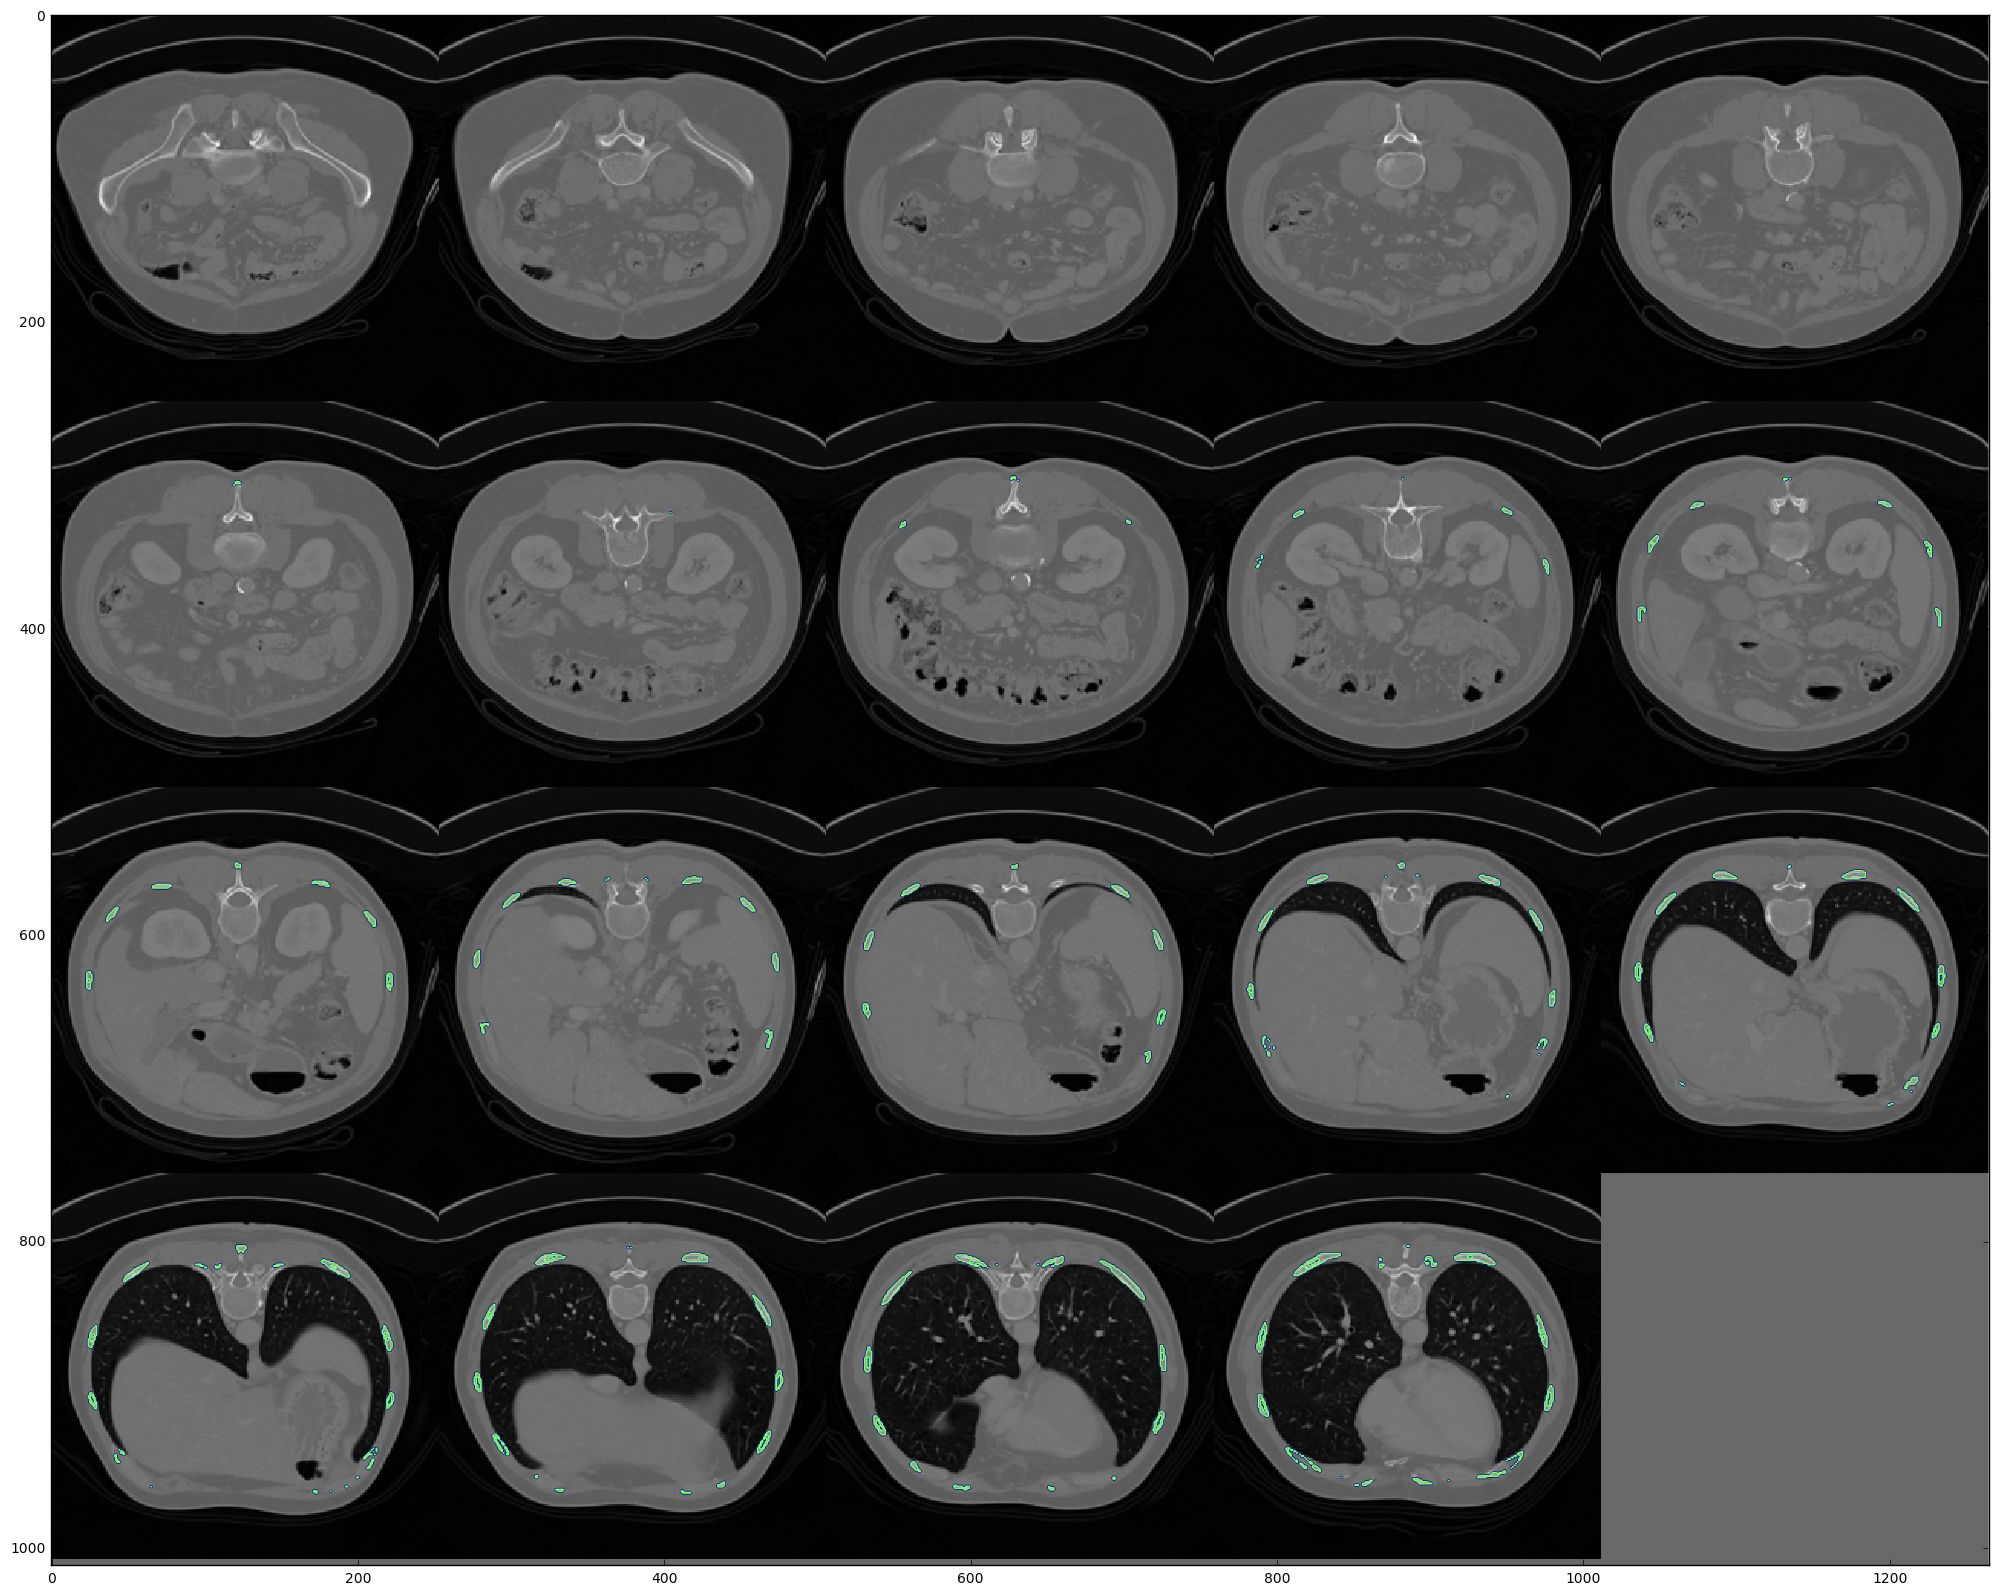

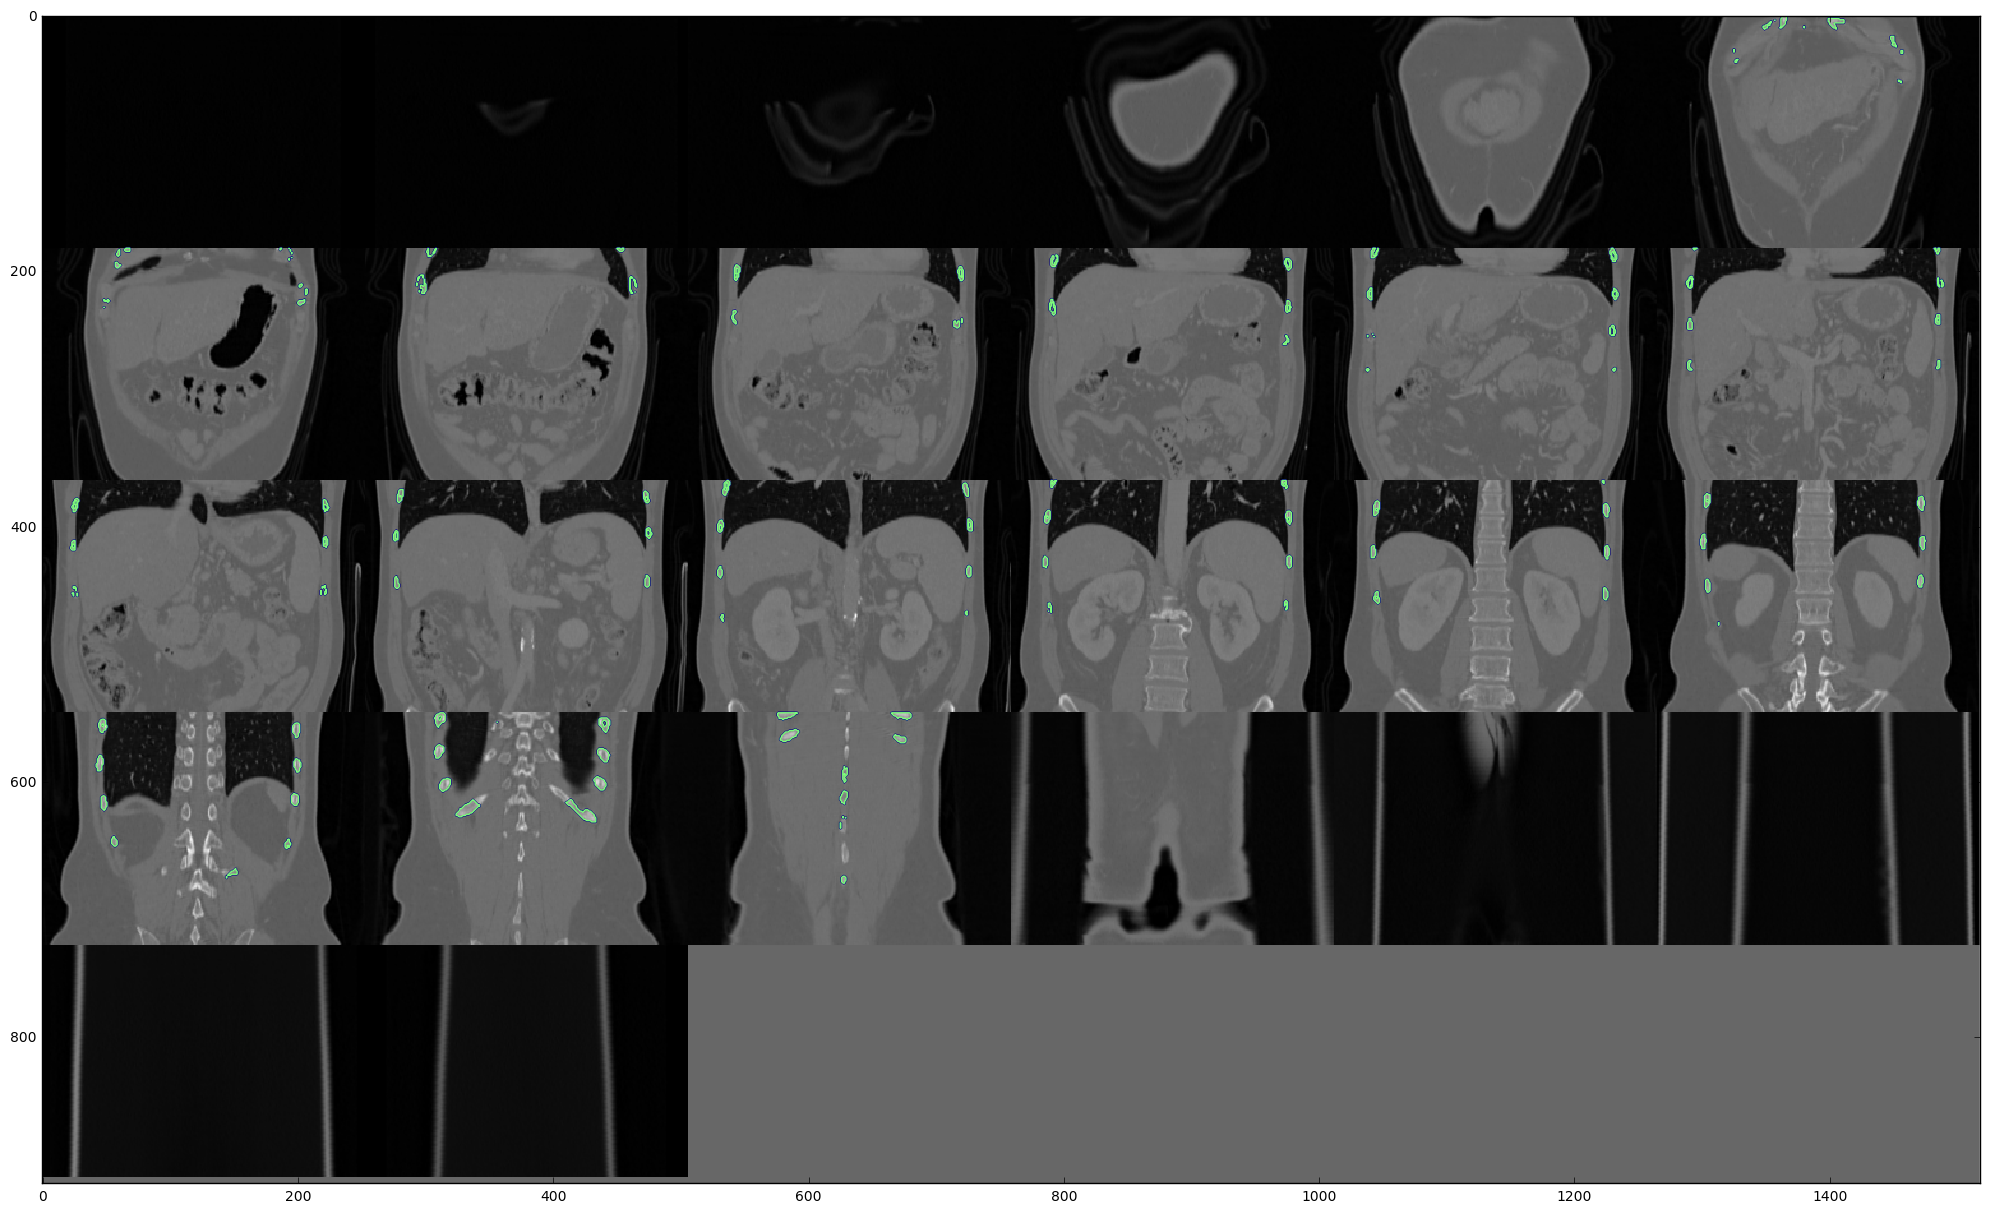

In [7]:
# Detekce zeber
ribs = bona_object.get_ribs()
# Vykresleni zeber
chest_localization.print_it_all(bona_object, data3dr_tmp, ribs*2, pattern)
# Vykresleni zeber zepredu
chest_localization.print_it_all_front(bona_object, data3dr_tmp, ribs*2, pattern)

### Detekce hrudníku

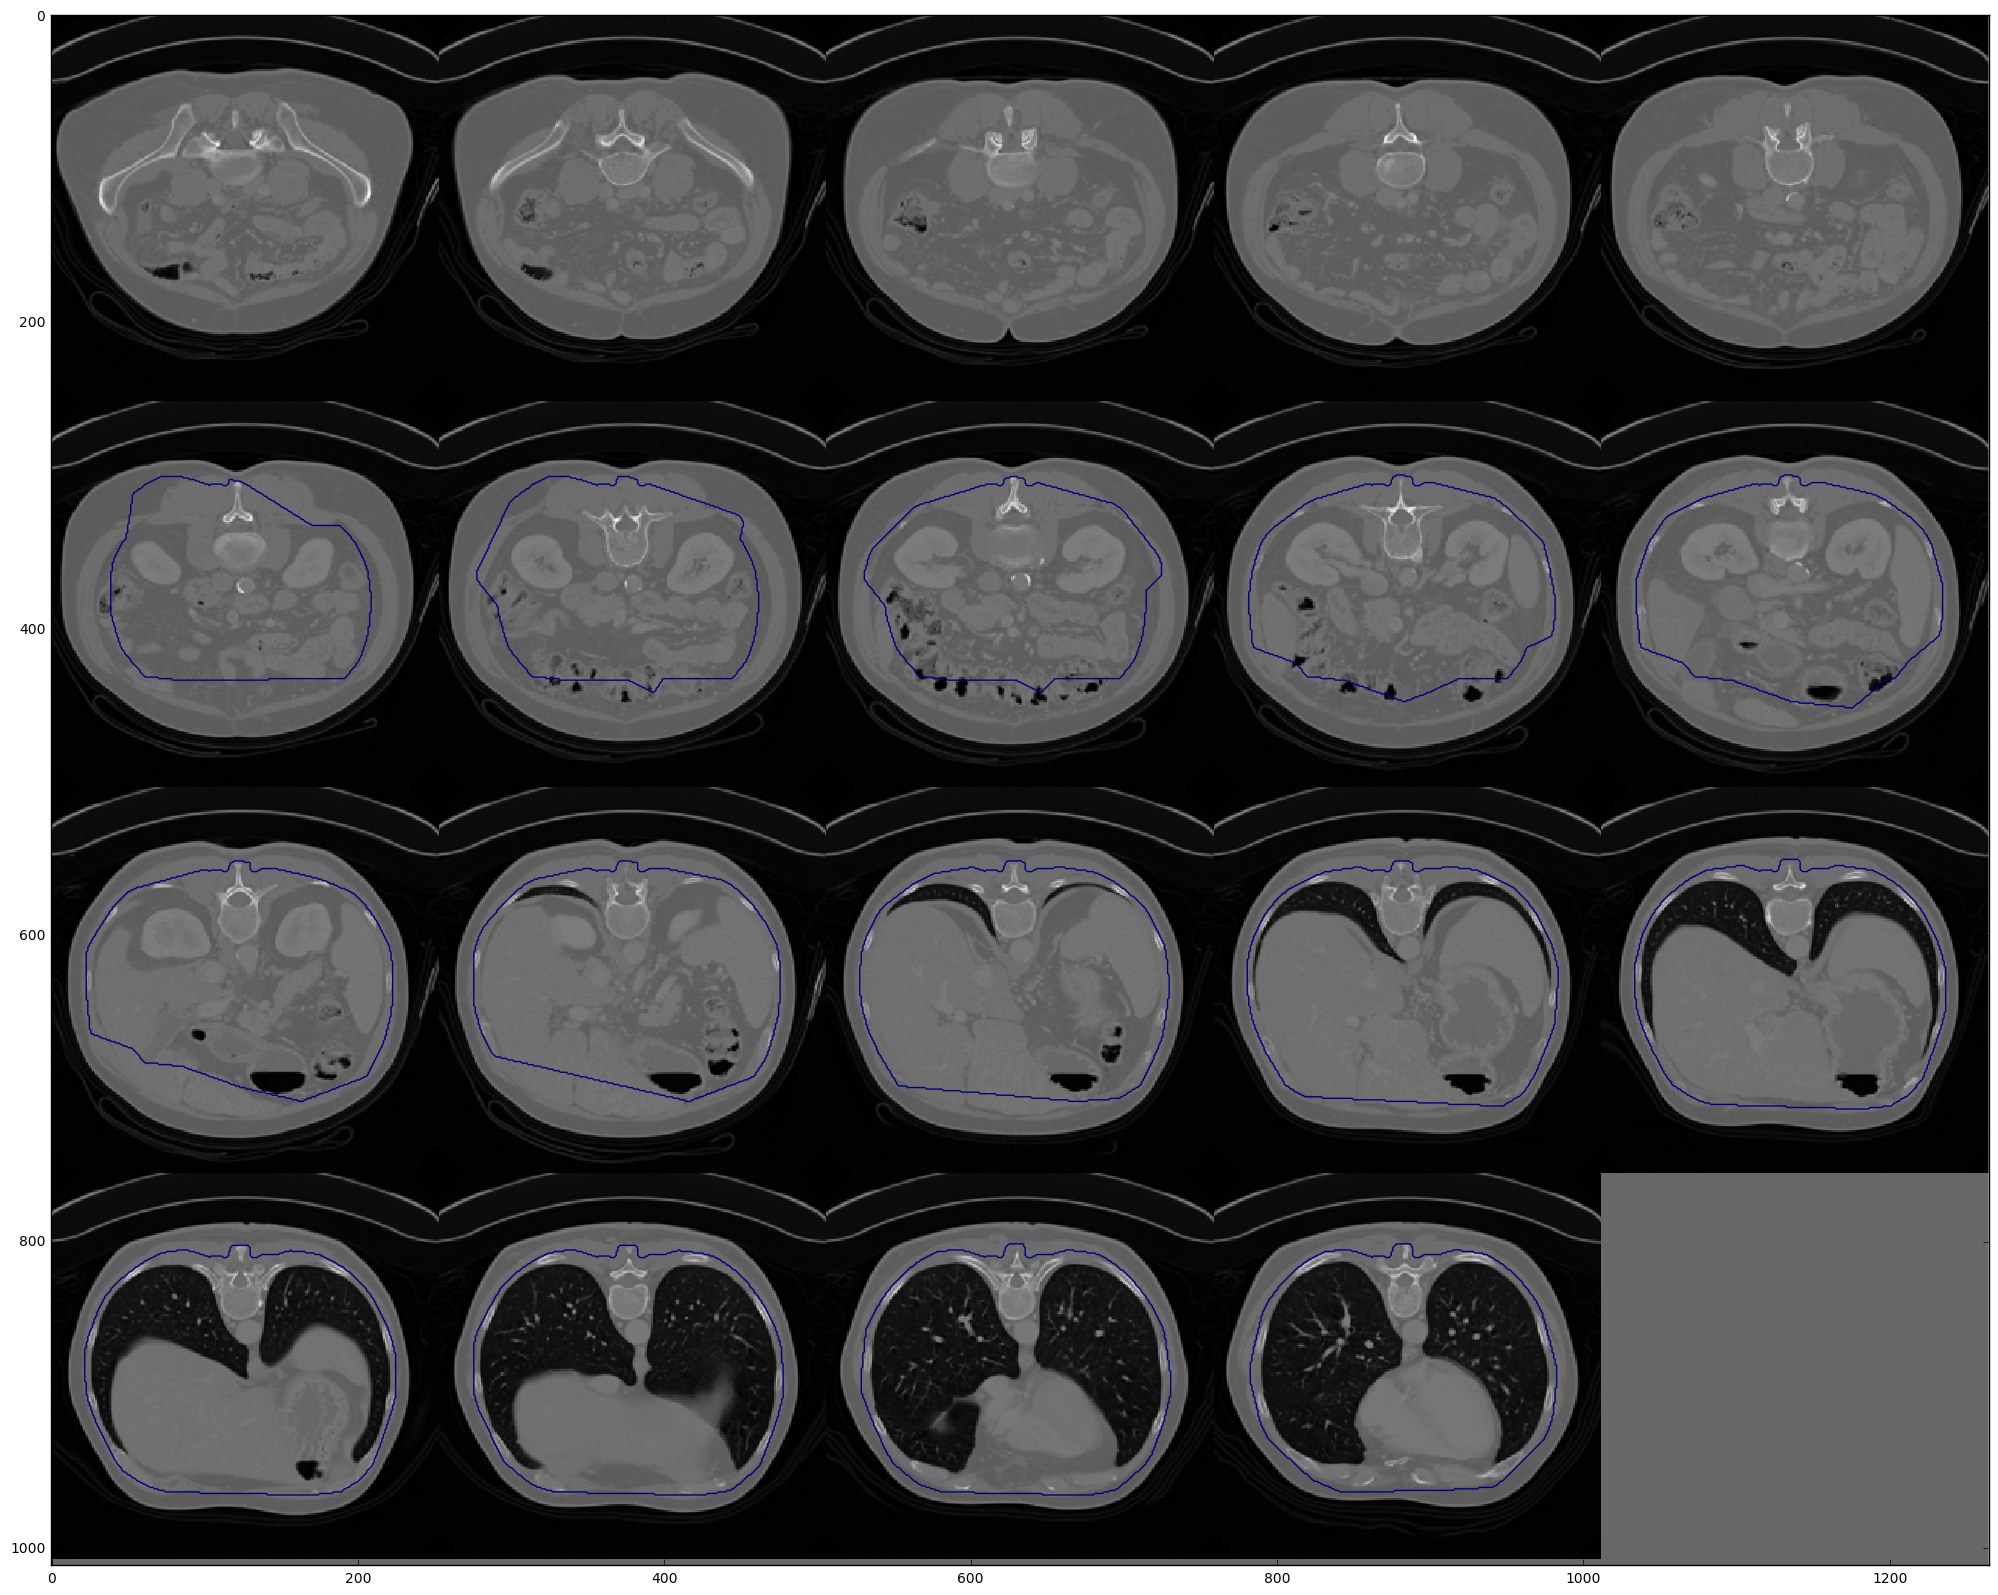

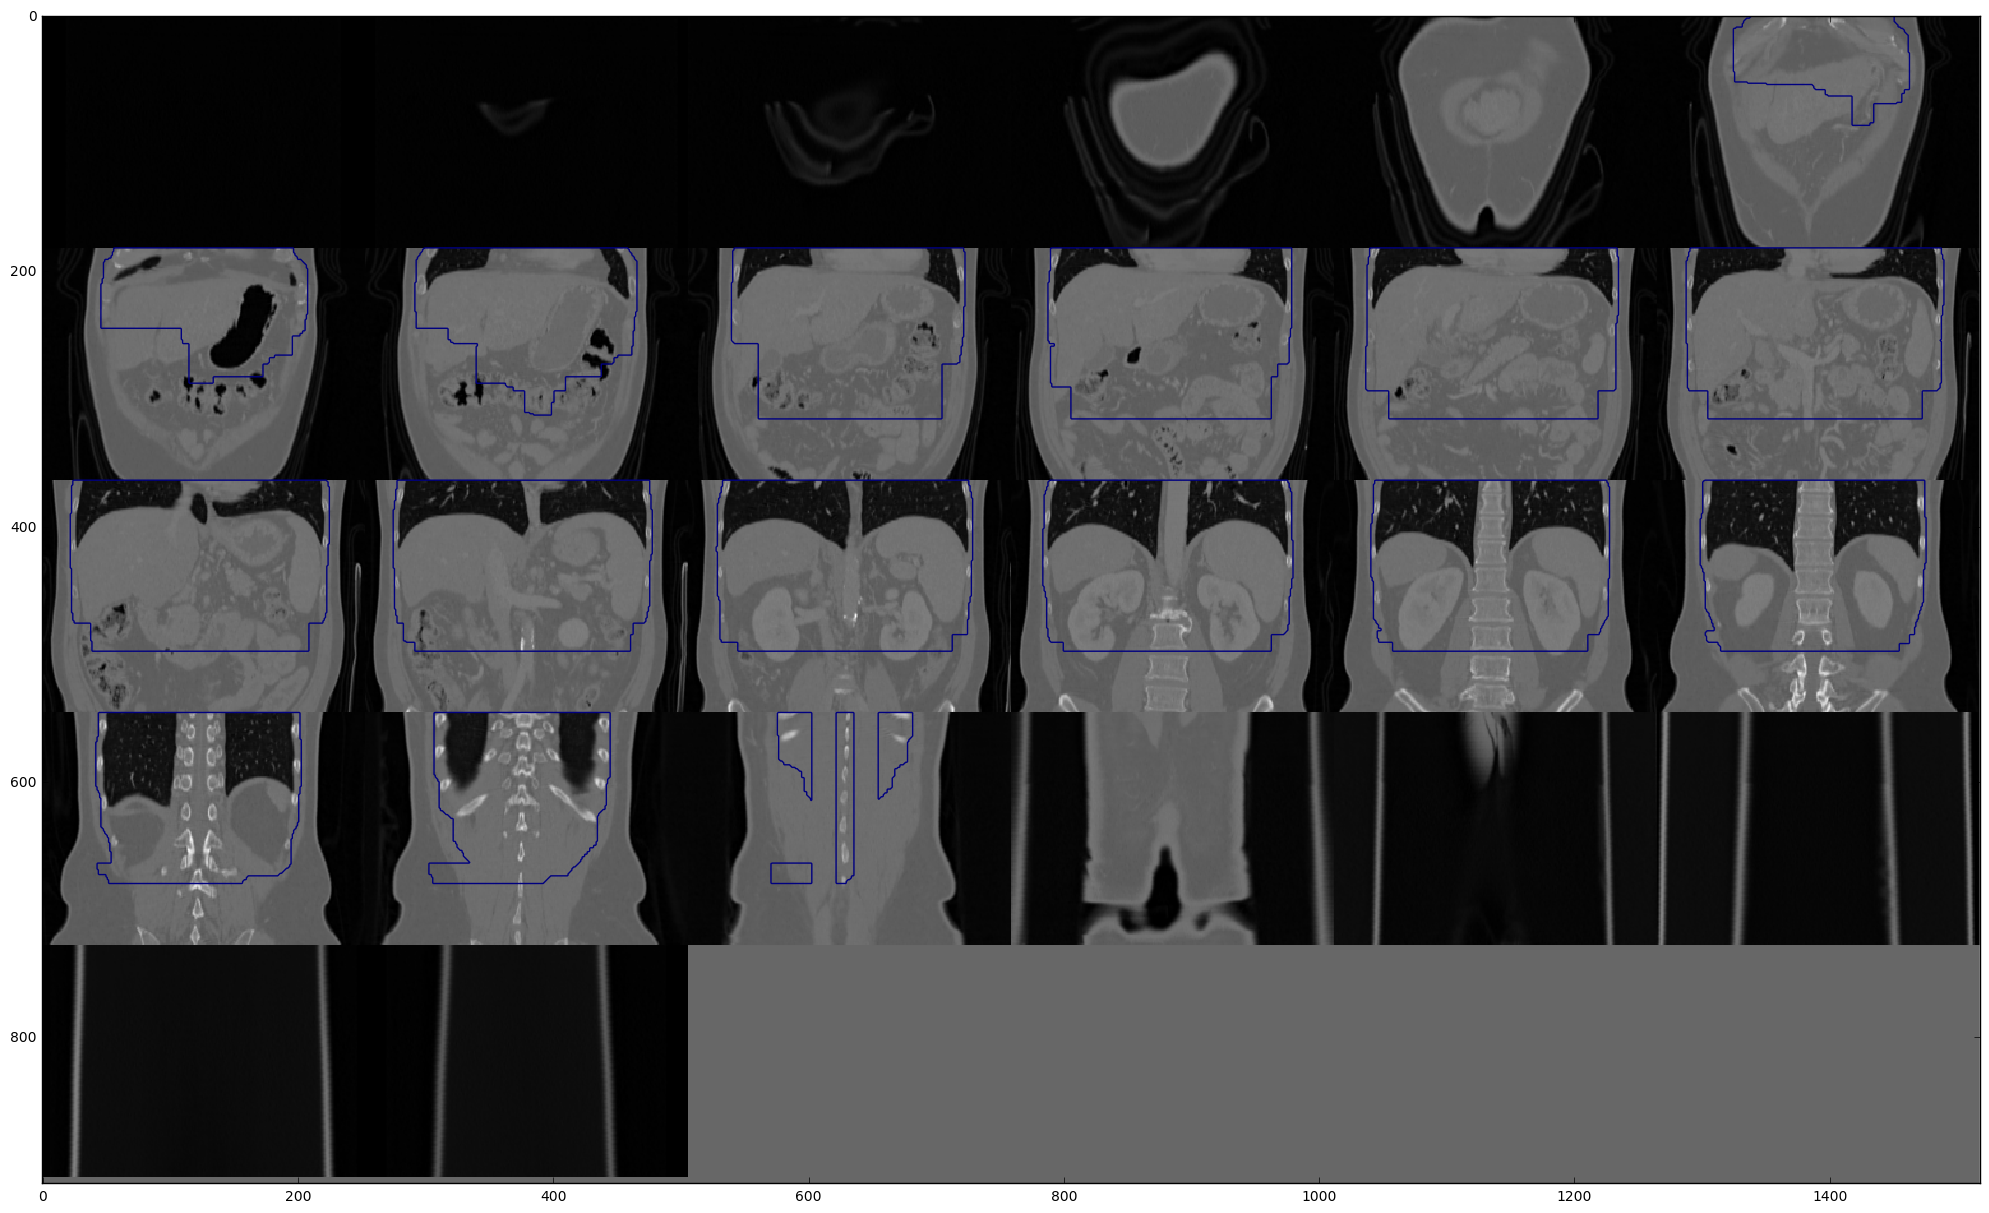

In [8]:
# Detekce hrudniku
chest = bona_object.get_chest()

# Vykresleni hrudniku
chest_localization.print_it_all(bona_object, data3dr_tmp, chest, pattern)
# Vykresleni hrudniku zepredu
chest_localization.print_it_all_front(bona_object, data3dr_tmp, chest, pattern)